In [1]:
import os
import cv2
import glob
import math
import time
import random
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join


import matplotlib.cm as cm

import tensorflow as tf

In [2]:
# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 400      
    
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

In [3]:
pixels = 28

In [4]:
#true size of image is Height = 480, Width = 640
imgHeight = 120
imgWidth = 160

In [5]:
encoder = LabelEncoder()

In [12]:
X_train = []
y_train = []

In [13]:
for j in range(10):
    mypath = "/home/john/Documents/Kaggle/StateFarm/imgs/train/c"+ str(j)
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for i in range(15):
    #for i in range(len(onlyfiles)):
        img = cv2.imread((mypath+"/"+onlyfiles[i]),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(imgHeight, imgWidth ))
        img = np.reshape(img, (imgHeight* imgWidth))
        X_train.append(img)
        y_train.append(j)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1,random_state = 42)

#X_train = X_train.reshape(X_train.shape[0], 1, pixels, pixels).astype('float32') / 255.
#X_test = X_test.reshape(X_test.shape[0], 1, pixels, pixels).astype('float32') / 255.

In [15]:
X_train[0].reshape(imgHeight,imgWidth).shape

(120, 160)

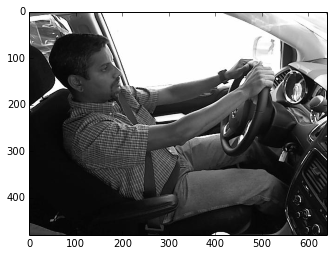

In [18]:
img = cv2.imread("/home/john/Documents/Kaggle/StateFarm/imgs/train/c0/img_34.jpg",cv2.IMREAD_GRAYSCALE)
#img = cv2.resize(img,(imgHeight, imgWidth,))
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

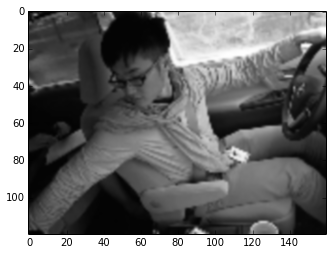

In [12]:
img = X_train[0].reshape(imgHeight, imgWidth )
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

In [19]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [20]:
y_train = dense_to_one_hot(y_train, 10)
y_train = y_train.astype(np.uint8)

In [21]:
y_test =dense_to_one_hot(y_test, 10)
y_test = y_test.astype(np.uint8)                         

In [22]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [23]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [24]:
#pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [25]:
image_size = imgHeight * imgWidth
labels_count = y_test.shape[1]

In [26]:

# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [27]:
numfilters1 = 32
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, numfilters1])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,imgHeight, imgWidth ,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, imgHeight, imgWidth,  4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, imgHeight*4, imgWidth*8)) 

In [28]:
numfilters2 = 64
# second convolutional layer
W_conv2 = weight_variable([5, 5, numfilters1, numfilters2])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)
imgHeightP1 = (imgHeight-2)/2+1
imgWidthP1 = (imgWidth-2)/2+1
# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, imgHeightP1, imgWidthP1,  4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, imgHeightP1*4, imgWidthP1*16)) 

In [29]:
imgHeightP2 = (imgHeightP1-2)/2+1
imgWidthP2 = (imgWidthP1-2)/2+1

# densely connected layer
W_fc1 = weight_variable([imgWidthP2 *imgHeightP2 *  numfilters2, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, imgHeightP2*imgWidthP2*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [30]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [31]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

In [32]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [33]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [34]:
train_images = X_train
train_labels = y_train

[0 0 0 0 0 0 0 0 0 1]


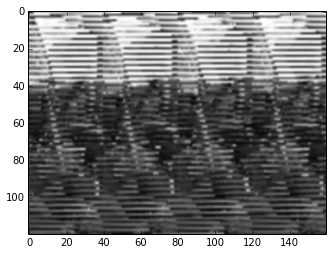

In [35]:
number = 25
img = train_images[number].reshape(imgHeight, imgWidth)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
print(y_train[number])

In [31]:
y_train[1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [27]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [28]:
validation_images = X_test
validation_labels = y_test

In [29]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

In [30]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 1.0})  
        
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.08 / 0.18 for step 0
training_accuracy / validation_accuracy => 0.08 / 0.12 for step 1
training_accuracy / validation_accuracy => 0.08 / 0.12 for step 2
training_accuracy / validation_accuracy => 0.12 / 0.12 for step 3
training_accuracy / validation_accuracy => 0.06 / 0.12 for step 4
training_accuracy / validation_accuracy => 0.12 / 0.12 for step 5
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 6
training_accuracy / validation_accuracy => 0.12 / 0.12 for step 7
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 8
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 9
training_accuracy / validation_accuracy => 0.14 / 0.12 for step 10
training_accuracy / validation_accuracy => 0.10 / 0.12 for step 20
training_accuracy / validation_accuracy => 0.16 / 0.12 for step 30
training_accuracy / validation_accuracy => 0.14 / 0.12 for step 40
training_accuracy / validation_accuracy => 0.04 / 0.12 for step 50
train

KeyboardInterrupt: 

In [ ]:
saver = tf.train.saver()
saver.save(sess, "statefarm1.ckpt")

In [ ]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [ ]:
#read in test data
mypath = "/home/john/Documents/Kaggle/StateFarm/imgs/test"
X_test = []
X_test_id = []
total = 0
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for i in range(len(onlyfiles)):
        flbase = os.path.basename(onlyfiles[i])
        img = cv2.imread((mypath+"/"+onlyfiles[i]),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (imgWidth,imgHeight))
        img = np.reshape(img, (imgHeight* imgWidth))
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1

In [ ]:
X_test = np.array(X_test)
X_test_id = np.array(X_test_id)

#X_test = X_test.reshape(X_test.shape[0], 1, pixels, pixels).astype('float32') / 255.

In [ ]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(imgWidth, imgHeight)
    
    plt.axis('off')
    plt.imshow(one_image, cmap='gray')

# output image     
display(image1)

In [ ]:
sess.close()